In [15]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical
#from tensorflow import keras 
#from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("datasets/nlp-getting-started/train.csv")

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


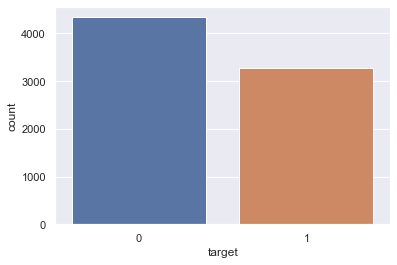

In [8]:
sns.set_theme()
ax = sns.countplot(x="target", data=df)

In [9]:
x = df.text.values
y = df.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [18]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)
dummy_y_train = to_categorical(encoded_Y_train)

In [ ]:
### save encoder for later

In [ ]:
### save encoder for later

In [19]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [20]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [21]:
do_lower_case

False

In [22]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [23]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [24]:
print('Tokenized Tweets shape', tweets.shape.as_list())

Tokenized Tweets shape [6090, None]


In [25]:
tweets[0]

<tf.Tensor: shape=(23,), dtype=int32, numpy=
array([ 48939,  47173,  10149,  11951,  10529,  10114,  10149,    169,
        11057, 100563,  27244,  10123,  11327,  10105,  28245,  10108,
        14909,  10111,  21180,    119,    119,    119,    102],
      dtype=int32)>

In [26]:
x_train[0]

'Seriously do we have to do a tactical riot against the headquarters of Disney and Marvel...'

In [27]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Seri [48939]
##ously [47173]
do [10149]
we [11951]
have [10529]
to [10114]
do [10149]
a [169]
ta [11057]
##ctical [100563]
rio [27244]
##t [10123]
against [11327]
the [10105]
headquarters [28245]
of [10108]
Disney [14909]
and [10111]
Marvel [21180]
. [119]
. [119]
. [119]


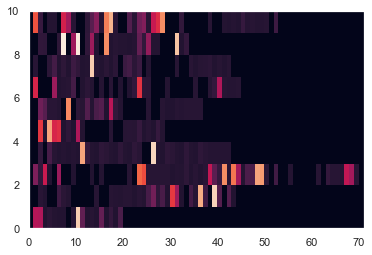

In [28]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

In [29]:
input_word_ids

<tf.RaggedTensor [[101, 48939, 47173, 10149, 11951, 10529, 10114, 10149, 169, 11057, 100563, 27244, 10123, 11327, 10105, 28245, 10108, 14909, 10111, 21180, 119, 119, 119, 102], [101, 146, 11850, 10162, 169, 137, 17665, 12078, 10556, 131, 120, 120, 188, 119, 11170, 120, 194, 11396, 10858, 10410, 11305, 11305, 10161, 11779, 10637, 20172, 31692, 13574, 20584, 10106, 64321, 42396, 10147, 119, 18987, 11170, 91622, 17904, 116, 102093, 23685, 118, 23493, 10218, 102], [101, 34658, 14091, 54521, 10107, 108, 42167, 111, 175, 10123, 132, 111, 175, 10123, 132, 10556, 131, 120, 120, 188, 119, 11170, 120, 74053, 68430, 11127, 11274, 11310, 11403, 11305, 10150, 10686, 10365, 13034, 10186, 11779, 10233, 11779, 51829, 25641, 15682, 83243, 11403, 77836, 44068, 10410, 21469, 21038, 89563, 86643, 11779, 158, 18686, 100, 168, 10556, 131, 120, 120, 188, 119, 11170, 120, 14535, 11517, 11211, 10477, 51658, 44026, 11127, 102], [101, 137, 14247, 168, 20220, 11517, 10113, 10731, 10123, 11090, 10133, 89525, 15311

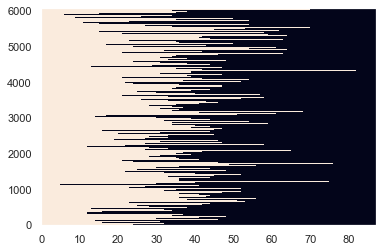

In [30]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

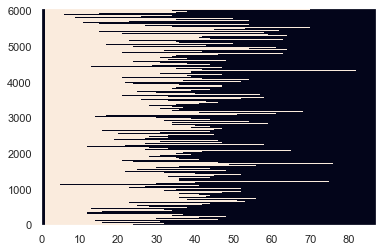

In [31]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [32]:
input_type_ids

<tf.Tensor: shape=(6090, 87), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [33]:
lens = [len(i) for i in input_word_ids]

In [35]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 87


In [36]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 130


In [37]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [38]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [39]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [41]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [42]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 130)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 130)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 130)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [44]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
381/381 [==============================] - 2947s 8s/step - loss: 0.5643 - accuracy: 0.7036 - val_loss: 0.4397 - val_accuracy: 0.8063
Epoch 2/3
381/381 [==============================] - 2866s 8s/step - loss: 0.3621 - accuracy: 0.8601 - val_loss: 0.4318 - val_accuracy: 0.8142
Epoch 3/3
381/381 [==============================] - 2818s 7s/step - loss: 0.2660 - accuracy: 0.8979 - val_loss: 0.4772 - val_accuracy: 0.8188


In [45]:
#model.save("BERT_Disaster_Calssification")

INFO:tensorflow:Assets written to: BERT_Disaster_Calssification/assets


INFO:tensorflow:Assets written to: BERT_Disaster_Calssification/assets


In [46]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9307
Testing Accuracy:  0.8188


In [47]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

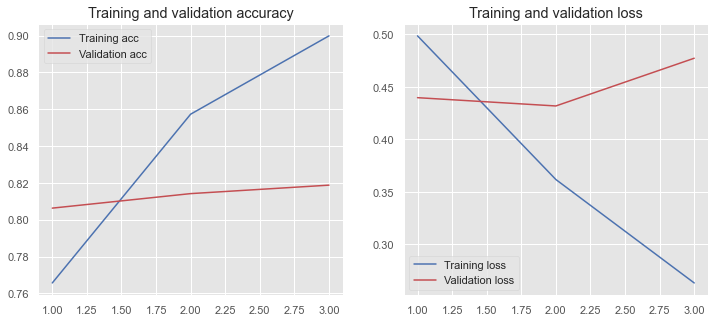

In [48]:
plot_history(history)

In [49]:
model.save("BERT_Disaster_CalssificationV2")

INFO:tensorflow:Assets written to: BERT_Disaster_CalssificationV2/assets


INFO:tensorflow:Assets written to: BERT_Disaster_CalssificationV2/assets


In [50]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model_fname = 'Disaster_BERT'
my_wd = 'datasets/nlp-getting-started'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: datasets/nlp-getting-started/Disaster_BERT/assets


INFO:tensorflow:Assets written to: datasets/nlp-getting-started/Disaster_BERT/assets


In [52]:
model_fname = 'Disaster_BERT'
my_wd = 'datasets/nlp-getting-started'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [53]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8188


In [54]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 130)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 130)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 130)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [55]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [56]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

Seri [48939]
##ously [47173]
do [10149]
we [11951]
have [10529]
to [10114]
do [10149]
a [169]
ta [11057]
##ctical [100563]
rio [27244]
##t [10123]
against [11327]
the [10105]
headquarters [28245]
of [10108]
Disney [14909]
and [10111]
Marvel [21180]
. [119]
. [119]
. [119]
